# Decorrelating the data and dimension reduction

Dimension reduction summarizes a dataset using its common occuring patterns. In this notebook, we'll learn about the most fundamental of dimension reduction techniques, "Principal Component Analysis" ("PCA"). PCA is often used before supervised learning to improve model performance and generalization. It can also be useful for unsupervised learning. For example, we'll employ a variant of PCA that will allow us to cluster Wikipedia articles by their content!

In [1]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from scipy.stats import pearsonr

import config
import utils
import numpy as np
from numpy.core import ndarray
import pandas as pd
from pandas.core.frame import Series, DataFrame
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict, List, Any, Union

In [2]:
basedir: str = os.getcwd()

In [3]:
datapaths: Dict[str, str] = {k: utils.normabspath(basedir, v) for k, v in config.paths.items()}
datapaths.keys()

dict_keys(['seeds', 'seeds-width-vs-length', 'artists', 'scrobbler-small-sample', 'wikipedia-vectors', 'wikipedia-vocabulary', 'stocks', 'eurovision', 'wine'])

In [4]:
wine = pd.read_csv(datapaths['wine'])
wine

,class_label,class_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1,Barolo,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,Barolo,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,Barolo,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,Barolo,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,Barolo,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,Barbera,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,Barbera,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,Barbera,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,Barbera,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


## Section 1.1: Step 1: Decorrelation of the data features

In [6]:
model = PCA()
pca_features: ndarray = model.fit_transform(wine[['od280', 'total_phenols']])

xs: ndarray = pca_features[:, 0]
ys: ndarray = pca_features[:, 1]

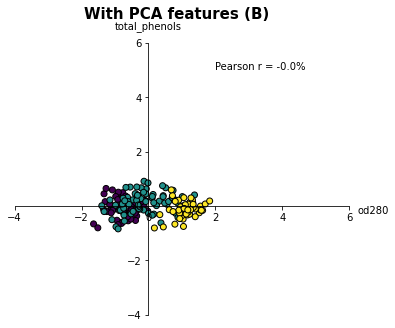

In [7]:
utils.scatter_axis(pd.Series(xs, name='od280'), 
                   pd.Series(ys, name='total_phenols'), 
                   class_labels=wine['class_label'],
                   xlim=(-4, 6), 
                   ylim=(-4, 6), 
                   align_axis_zero=True, 
                   save=False, 
                   name='total_phenols_vs_od280_pca',
                   title='With PCA features (B)',
                   xy=(2, 5))

In [8]:
correlation, pvalue = pearsonr(xs, ys)
correlation

-1.6653345369377348e-16

In [9]:
model.components_

array([[-0.76740167, -0.64116665],
       [ 0.64116665, -0.76740167]])

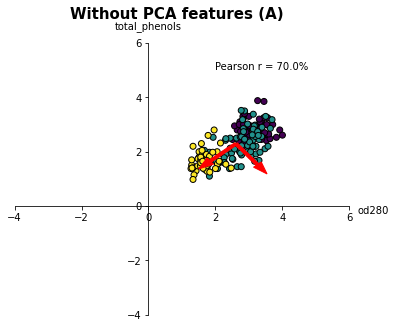

In [10]:
utils.scatter_axis(wine['od280'], 
                   wine['total_phenols'], 
                   class_labels=wine['class_label'],
                   xlim=(-4, 6), 
                   ylim=(-4, 6), 
                   align_axis_zero=True, 
                   save=False, 
                   name='total_phenols_vs_od280',
                   title='Without PCA features (A)',
                   xy=(2, 5),
                   model=model)

In [11]:
correlation, pvalue = pearsonr(wine['od280'], wine['total_phenols'])
correlation

0.6999493647911862

## Section 1.2: Step 2: Variance of the PCA features
The wine dataset has 13 dimensions. But what is its **intrinsic** dimension? Here, we will make a plot of the variances of the PCA features to find out. We'll need to standardize the features first.

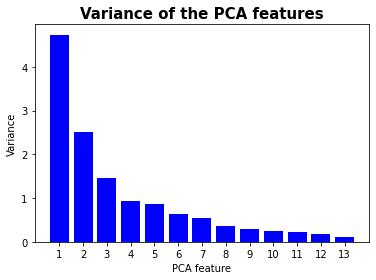

In [12]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
target_cols: List[str] = ['class_label', 'class_name']
pipeline.fit(wine.drop(target_cols, axis=1))
features = range(1, pca.n_components_ + 1)

plt.bar(features, pca.explained_variance_, color='b')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title('Variance of the PCA features', fontweight='bold', fontsize=15)
# plt.savefig('out/plots/bar_pca_features_variance.png', dpi=600, transparent=True)
plt.show()

It looks like PCA features 0 to 2 exhibit significant variance.

## Section 1.3: Dimension reduction

In [13]:
pca = PCA(n_components=3)
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(wine.drop(target_cols, axis=1))
pca_features: ndarray = pipeline.transform(wine.drop(target_cols, axis=1))
pca_features.shape

(178, 3)